In [2]:
import os, import_ipynb
os.chdir('../')
from Utils import *

importing Jupyter notebook from Utils.ipynb


In [3]:
#time_series= load_time_series(gsr=True)
time_series = pd.read_csv('data/1_time_series/gsr/1001010.csv', index_col=0)
frames, ys  = load_frames('/nfs/nfs-davinci/fahad/biobank/data/eprime_files/1001010_25748_2_0.txt', time_series)
rois        = np.array(time_series.columns)

In [4]:
chunks, corrs, window_ys, window_times = window_timeseries(time_series, window=10, ys=ys, kind='correlation')
crosscorrs, lags, covs                 = compute_tvfcn_crosscorrs_covs_full(chunks, zerolag=False)

In [5]:
results, rels   = get_edge_types(covs, lags, rois, window_ys)
counts          = count_edge_types(results, rels)

In [6]:
def get_preds(mat, window_ys):
    mean_face  = mat[mat.columns[np.array(window_ys)=='Face']].mean(axis=1).values.reshape(len(rois), len(rois))
    mean_shape = mat[mat.columns[np.array(window_ys)=='Shape']].mean(axis=1).values.reshape(len(rois), len(rois))
    mean_face  = pd.DataFrame(mean_face)
    mean_shape = pd.DataFrame(mean_shape)
    face_diffs = [1-cosine(mat[col], mean_face.values.flatten()) for col in mat.columns]
    shape_diffs= [1-cosine(mat[col], mean_shape.values.flatten()) for col in mat.columns]
    preds      = np.array(['Face' if face_diffs[idx]>shape_diffs[idx] else 'Shape' for idx in range(len(face_diffs))])
    
    return preds, mean_face-mean_shape, face_diffs, shape_diffs

In [7]:
corrs_df = pd.DataFrame([corr.values.flatten() for corr in corrs]).transpose()
corrs_df.index = lags.index
corrs_df[lags>0] = 0
preds, diff, face_diffs, shape_diffs = get_preds(corrs_df, window_ys)
print(classification_report(window_ys, preds))

                 precision    recall  f1-score   support

EightSecFixPROC       0.00      0.00      0.00         5
           Face       0.87      1.00      0.93        13
          Shape       0.83      1.00      0.91        15

       accuracy                           0.85        33
      macro avg       0.57      0.67      0.61        33
   weighted avg       0.72      0.85      0.78        33



/home/fahad/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fahad/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fahad/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
corrs_df.columns = ["%s. %s" % (idx, corrs_df.columns[idx]) for idx in range(len(corrs_df.columns))]

In [10]:
corrs_df.columns = window_ys

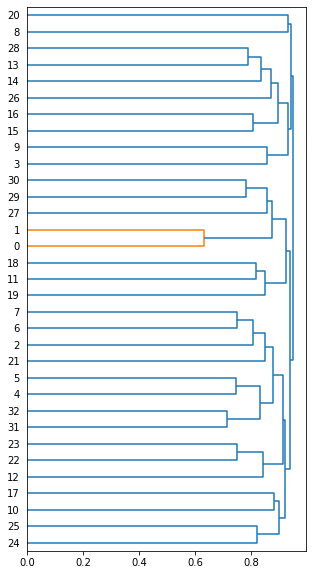

In [8]:
plt.figure(figsize=(5, 10));
linkage_matrix, color_thresh, reorderedcols, clusters, dn = cluster_matrix(corrs_df.transpose(), toplot=True, metric='cosine')

In [32]:
from sklearn.metrics.pairwise import cosine_distances
dists = 1-cosine_distances(corrs_df.transpose())

In [52]:
cosine([1], [0]), cosine([1], [-1]), cosine([1], [1])

(nan, 2.0, 0.0)

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, precompute_distances=True)
kmeans.fit(dists)
labels = kmeans.labels_
for label in set(labels):
    a = np.array(window_ys)[labels==label]
    print(a)

['Shape' 'Shape' 'Shape' 'Face' 'Face' 'EightSecFixPROC' 'Face' 'Shape'
 'Shape' 'Shape']
['Face' 'Face' 'EightSecFixPROC' 'Shape' 'Shape' 'Shape' 'EightSecFixPROC'
 'Shape' 'Shape' 'Shape']
['Shape' 'Shape' 'Shape' 'Face' 'Face' 'EightSecFixPROC' 'Face' 'Face'
 'EightSecFixPROC' 'Face' 'Face' 'Face' 'Face']


/home/fahad/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)


In [ ]:
mean_diff = pd.DataFrame(diff.values.flatten())
linkage_matrix, color_thresh, reorderedcols, clusters, dn = cluster_matrix(mean_diff)
plt.hist(abs(mean_diff[0].values), bins=50);
# plt.figure();
# plt.imshow(mean_diff.loc[reorderedcols], cmap='coolwarm', aspect='auto');
# plt.colorbar();

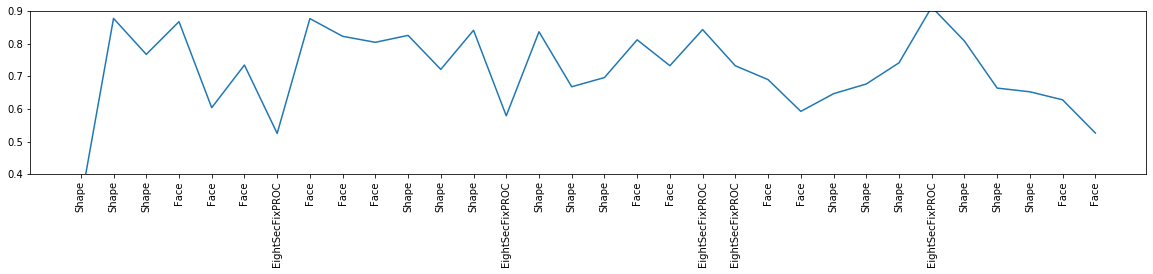

In [60]:
instability = [cosine(corrs_df[idx], corrs_df[idx-1]) for idx in range(1, corrs_df.shape[1])]
plt.figure(figsize=(20, 3));
plt.plot(instability);
plt.xticks(range(len(instability)), window_ys, rotation=90);
plt.ylim(0.4, 0.9);

In [22]:
mean_face  = corrs_df[corrs_df.columns[np.array(window_ys)=='Face']].mean(axis=1)#.values.reshape(len(rois), len(rois))
mean_shape = corrs_df[corrs_df.columns[np.array(window_ys)=='Shape']].mean(axis=1)#.values.reshape(len(rois), len(rois))

In [23]:
diff = mean_face-mean_shape
diff = diff.sort_values()
sig_edges = list(diff.index[:100])+list(diff.index[-100:])

In [63]:
corrs_df.shape

(2116, 33)

In [77]:
# shape_diffs = corrs_df
face_diffs   = [cosine(corrs_df.loc[sig_edges, t], mean_face.loc[sig_edges]) for t in range(1, corrs_df.shape[1])]
shape_diffs  = [cosine(corrs_df.loc[sig_edges, t], mean_shape.loc[sig_edges]) for t in range(1, corrs_df.shape[1])]

No handles with labels found to put in legend.


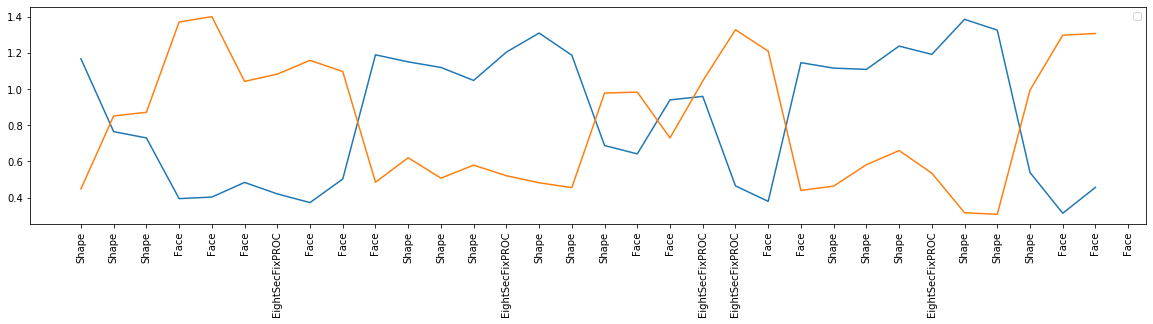

In [82]:
plt.figure(figsize=(20, 4));
plt.plot(face_diffs)
plt.plot(shape_diffs)
plt.xticks(range(len(window_ys)), window_ys, rotation=90);
plt.legend()


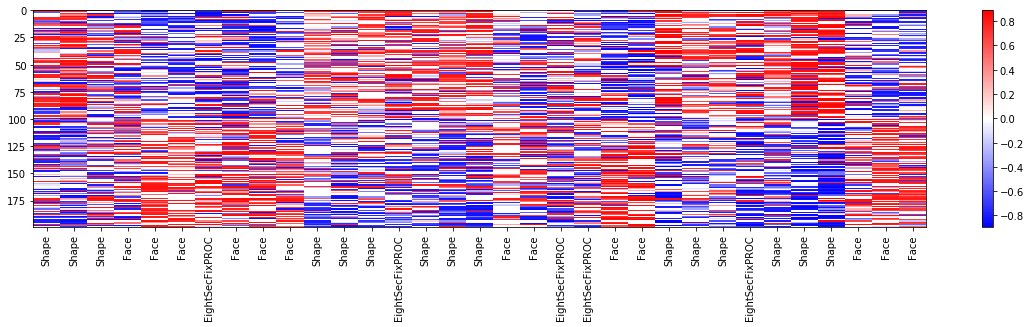

In [87]:
plt.figure(figsize=(20, 4));
plt.imshow(corrs_df.loc[sig_edges], aspect='auto', cmap='bwr');
plt.xticks(range(len(window_ys)), window_ys, rotation=90);
plt.colorbar();

In [56]:
face_edges = list(diff.index[:100])
shape_edges = list(diff.index[-100:])
# sig_edges2 = [e.replace(' > ', ', ') for e in sig_edges]
sig_edges2 = [e.replace(' > ', ', ') for e in face_edges]
common = set(sig_edges2).intersection(set(counts.index))

In [59]:
results = results.replace(rels).transpose()

In [53]:
edge = 'Planum Polare, Precentral Gyrus'
# edge = 'Cerebellum, Amygdala'
# all_types = results[edge]
# face_types = results.loc[results.index=='Face', edge]
# shape_types = results.loc[results.index=='Shape', edge]
counts2 = pd.concat([all_types.value_counts(), face_types.value_counts(), shape_types.value_counts()], axis=1).fillna(0).astype(int)
counts2.columns = ['all', 'face', 'shape']
# print(counts2)

In [60]:
# all_types = results[common]
face_types = results.loc[results.index=='Face', common]
shape_types = results.loc[results.index=='Shape', common]

face_counts = pd.Series(face_types.values.flatten()).value_counts()
shape_counts = pd.Series(shape_types.values.flatten()).value_counts()
counts3 = pd.concat([face_counts, shape_counts], axis=1).fillna(0).astype(int)
counts3.columns = ['face', 'shape']

In [61]:
counts3.apply(lambda x: round(x/sum(x), 2))

,face,shape
-,0.35,0.37
x >> y,0.30,0.08
x << y,0.16,0.13
x < y,0.13,0.16
x > y,0.06,0.27


In [51]:
#results
#rels
#counts
common = set(sig_edges2).intersection(set(counts.index))
# results.replace(rels).loc[common]
# counts.loc[common]

a = results.loc[['Planum Polare, Precentral Gyrus']].replace(rels).transpose()
b = corrs_df.loc['Planum Polare > Precentral Gyrus']
b.index = a.index

In [61]:
pd.concat([a, b], axis=1)[:10]

,"Planum Polare, Precentral Gyrus",Planum Polare > Precentral Gyrus
Shape,x << y,0.000000
Shape,-,0.000000
Shape,x <<>> y,-0.683426
Face,x >> y,-0.826985
Face,x <<>> y,-0.761563
Face,-,0.000000
EightSecFixPROC,x <<>> y,-0.855255
Face,x <<>> y,-0.840379
Face,x << y,0.000000
Face,-,-0.537300


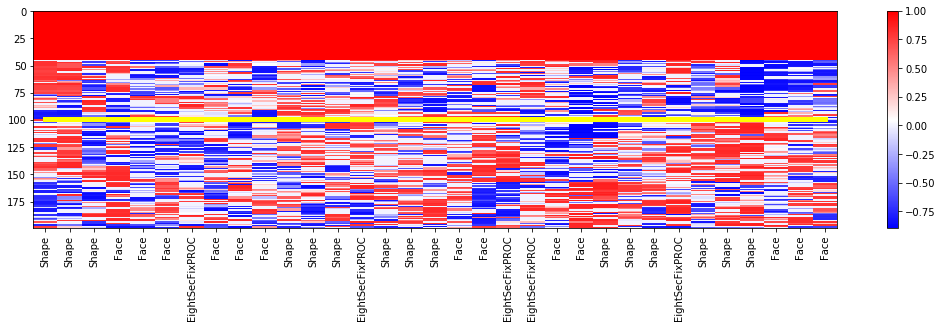

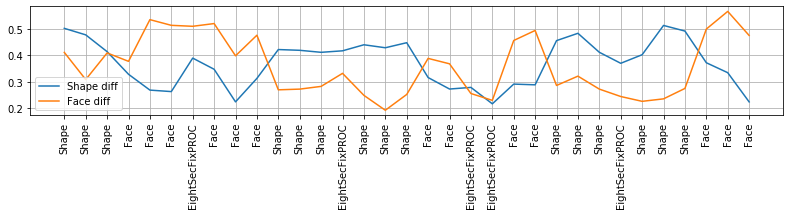

In [165]:
# fig, axs = plt.subplots(1, 4, figsize=(15, 3), gridspec_kw={'width_ratios': [10, 1, 10, 1]})
# a = axs[0].imshow(mean_face.loc[reorderedcols, reorderedcols], cmap='bwr');
# b = axs[2].imshow(mean_shape.loc[reorderedcols, reorderedcols], cmap='bwr');
# fig.colorbar(a, axs[1]);
# fig.colorbar(b, axs[3]);

plt.figure(figsize=(18, 4));
plt.imshow(corrs_df.loc[reorderedcols[:100]+reorderedcols[-100:]], aspect='auto', cmap='bwr');
plt.plot(range(len(window_ys)), [99]*len(window_ys), color='yellow', linewidth=5);
plt.xticks(range(len(window_ys)), window_ys, rotation=90);
plt.colorbar();

plt.figure(figsize=(13.5, 2));
plt.plot(shape_diffs);plt.plot(face_diffs);
# plt.ylim(0, 22);
plt.xticks(range(len(window_ys)), window_ys, rotation=90);
plt.legend(['Shape diff', 'Face diff'])
plt.grid();

In [4]:
mean_dynamics      = covs.mean(axis=1).values.reshape(len(rois), len(rois))
mean_abs_dynamics  = abs(mean_dynamics)

matrix             = ConnectivityMeasure(kind='correlation').fit_transform([time_series.values])[0]
matrix             = pd.DataFrame(matrix, columns=rois, index=rois)

100%|██████████| 2116/2116 [00:00<00:00, 78607.21it/s]


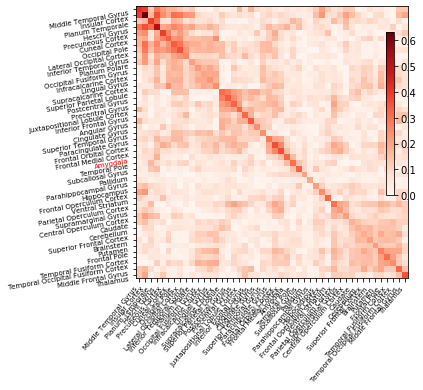

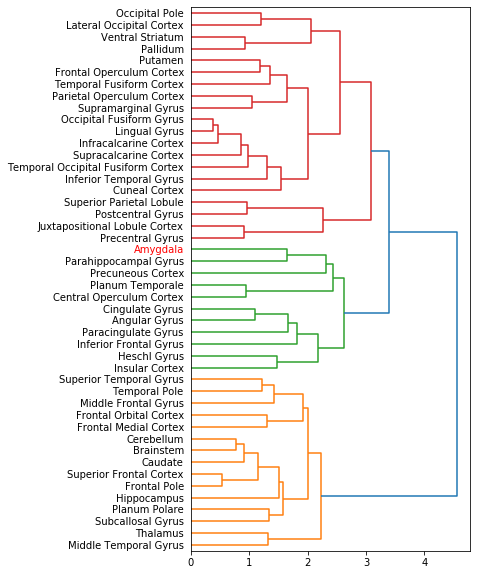

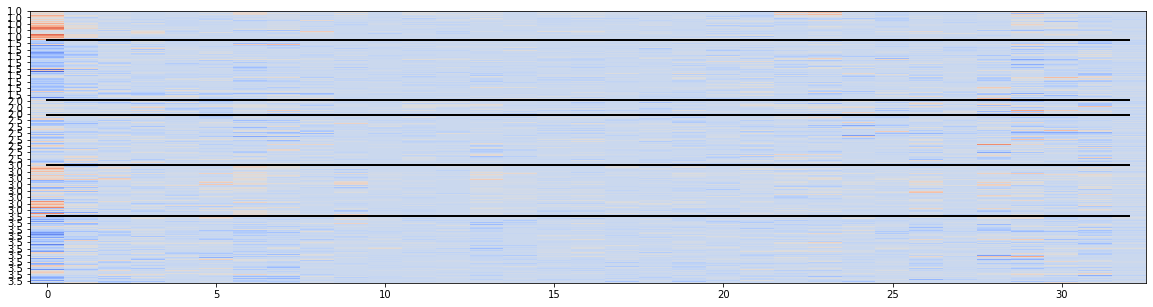

In [19]:
plotting.plot_matrix(mean_abs_dynamics, labels=rois, reorder=True, colorbar=True, cmap='Reds');#, axes=axs[0][0]);
[x.set_color("red") for x in plt.gca().get_yticklabels() if (x.get_text()=='Amygdala') or (x.get_text()=='Amygdala')];

plt.figure(figsize=(5, 10));
Z, thresh, orderedcols, clusters, dn = cluster_matrix(matrix, toplot=True)

edges, cluster_labels = reorder_edges_tvfcn(covs.index, rois, clusters)

plt.figure(figsize=(20, 5));
plt.imshow(covs.loc[edges], aspect='auto', cmap='coolwarm');

plt.yticks(range(len(edges))[::50], cluster_labels[::50]);

for cluster_boundary in np.argwhere(np.diff(cluster_labels)>0):
    plt.plot(range(covs.shape[1]), [cluster_boundary]*covs.shape[1], color='black', linewidth=2);


In [21]:
amygdala_cluster = clusters[np.argwhere(rois=='Amygdala')[0][0]]

In [22]:
rois[clusters==amygdala_cluster]

array(['Insular Cortex', 'Inferior Frontal Gyrus', 'Angular Gyrus',
       'Paracingulate Gyrus', 'Cingulate Gyrus', 'Precuneous Cortex',
       'Parahippocampal Gyrus', 'Central Operculum Cortex',
       'Heschl Gyrus', 'Planum Temporale', 'Amygdala'], dtype=object)

In [15]:
clusters = fcluster(linkage_matrix, t=5, criterion='maxclust')

In [17]:
colors = pd.DataFrame()
colors['leaves'] = dn['leaves']
colors['color'] = dn['leaves_color_list']
colors['roi'] = rois[np.array(dn['leaves'])]
colors = colors.set_index('roi')

In [ ]:
for cluster in set(clusters):
    cluster_rois      = rois[clusters==cluster]
    color             = colors.loc[cluster_rois, 'color'].iloc[0]
    results, rel_dict = get_edge_types(covs, lags, cluster_rois, window_ys)
    counts            = count_edge_types(results, rel_dict)
    labels            = counts[counts>20].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
    labels.columns    = ['nature', 'arrow']
    labels['pval']    = 0.001
    G                 = construct_graph(labels[:20])
    draw_graph(G, layout=nx.spring_layout, figsize=(8, 4), edgecolor=color, fontcolor=color);

In [25]:
np.argwhere(rois=='Amygdala')[0][0], len(labels)

(42, 120)

In [31]:
amygdala_cluster = clusters[np.argwhere(rois=='Amygdala')[0][0]]

In [33]:
rois[clusters==amygdala_cluster]

array(['Precuneous Cortex', 'Parahippocampal Gyrus',
       'Central Operculum Cortex', 'Planum Temporale', 'Amygdala'],
      dtype=object)

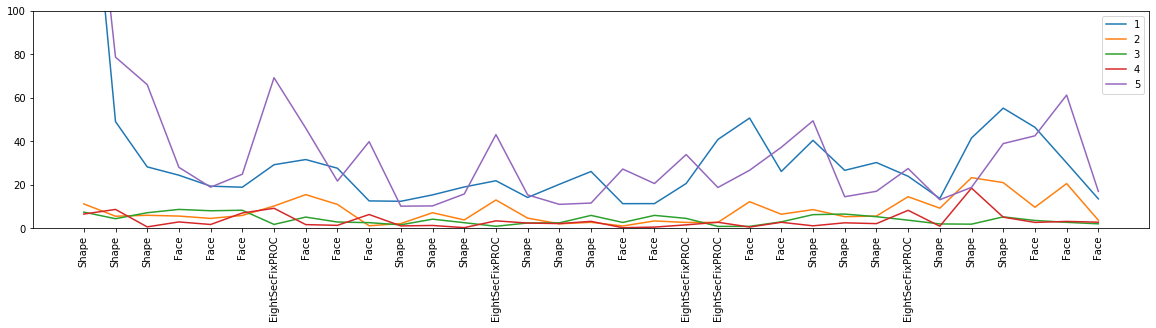

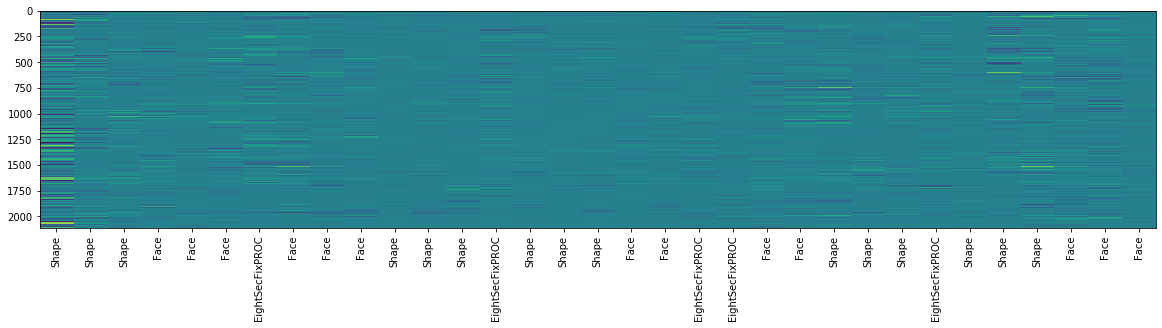

In [36]:
plt.figure(figsize=(20, 4))
for cluster in set(clusters):
    cluster = rois[clusters==cluster]
    plt.plot([abs(corr.loc[cluster, cluster]).sum().sum() for corr in corrs])
plt.xticks(range(len(corrs)), window_ys, rotation=90);
plt.legend(set(clusters));
plt.ylim(0, 100);

plt.figure(figsize=(20, 4));
plt.imshow(covs, aspect='auto');
plt.xticks(range(len(corrs)), window_ys, rotation=90);

In [ ]:

from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list, fcluster, dendrogram

linkage_matrix  = linkage(mean, method='average')
ordered_linkage = optimal_leaf_ordering(linkage_matrix, mean)
index           = leaves_list(ordered_linkage)
cols            = [rois[idx] for idx in index]

thresh = 0.5*max(linkage_matrix[:,2])#0.7*max(linkage_matrix[:,2])

plt.figure(figsize=(5, 10));
dn = dendrogram(linkage_matrix, labels=list(rois),\
        orientation='right', leaf_font_size=10, color_threshold=thresh)

[x.set_color("red") for x in plt.gca().get_yticklabels() if (x.get_text()=='Amygdala') or (x.get_text()=='Amygdala')];